In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo, PropertyIsLike, BBox
import pandas as pd
from ipyaggrid import Grid

csw = CatalogueServiceWeb('http://explorer-portal.australiaeast.cloudapp.azure.com/geonetwork/srv/eng/csw')

permit_query = PropertyIsEqualTo('csw:AnyText', '%Permits%')
csw.getrecords2(constraints=[permit_query], maxrecords=200)

data = {}
attribs = ['identifier', 'title', 'abstract', 'type', 'subjects' ]
for key in csw.records:
    record = csw.records[key]
    for attrib in attribs:
        if attrib not in data.keys():
            data[attrib] = []
        data[attrib].append(getattr(record, attrib))

df_record = pd.DataFrame(data)

record_column_defs = [{'field': c, 'width': 300, 'editable': True} for c in df_record.columns]

record_grid_options = {
    'columnDefs' : record_column_defs,
    'enableFilter':'true',
    'enableSorting':'true'
}

g_record = Grid(
    grid_data=df_record,
    grid_options=record_grid_options,
    theme='ag-theme-balham',
    columns_fit='',
    quick_filter=True,
    export_csv=True,
    export_excel=True
)

g_record

Grid(compress_data=True, export_mode='disabled', height='350px', menu={'buttons': [{'name': 'Export to CSV', '…

In [2]:
from owslib.csw import CatalogueServiceWeb

csw.getrecordbyid(id=['aecdf0b2b48a07a8f95888d245781b9dc2a3faec', 'b194c58124d86f7cab8a1890e8e51971ec6443d9'])

record = csw.records['aecdf0b2b48a07a8f95888d245781b9dc2a3faec']
petro_permit_layer = record.uris[0]

petro_permit_layer

{'protocol': 'OGC:WFS-1.1.0-http-get-feature',
 'name': 'Permits_Petroleum:Petroleum_Active_Permits',
 'description': 'Petroleum_Active_Permits',
 'url': 'https://data.nzpam.govt.nz/hosting/services/Permits/Petroleum/MapServer/WFSServer?'}

In [3]:
record = csw.records['b194c58124d86f7cab8a1890e8e51971ec6443d9']
mineral_permit_layer = record.uris[0]

mineral_permit_layer

{'protocol': 'OGC:WFS-1.1.0-http-get-feature',
 'name': 'Permits_Minerals:Mineral_Active_Permits',
 'description': 'Mineral_Active_Permits',
 'url': 'https://data.nzpam.govt.nz/hosting/services/Permits/Minerals/MapServer/WFSServer?'}

In [4]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS',
    version="2.0.0",
    request='GetFeature',
    typeName=petro_permit_layer['name'],
    outputFormat='geojson',
    srsname='urn:ogc:def:crs:EPSG::4326',
    bbox='173.56,-39.24,175.47,-36.44'
)
q = Request('GET', petro_permit_layer['url'], params=params).prepare().url

petroleum_df = gpd.read_file(q)

petroleum_df.head()

,OBJECTID,Permit_Number,PERMIT_NONEXCLUSIVE_YN,PERMIT_DURATION_YEARS,PERMIT_DURATION_MONTHS,PERMIT_AREA,PERMIT_AREA_UNITS,PERMIT_OFFSHORE_ONSHORE,Status,PERMIT_STATUS_DATE,...,Owner_s_,Share_Percentage_s_,Operator,Mineral_s_,B1_PER_ID1,B1_PER_ID2,B1_PER_ID3,SHAPE.STArea__,SHAPE.STLength__,geometry
0,15333,57065,N,10,0,52.176,SQKM,Onshore,Active,1/04/2015,...,TAMARIND NZ ONSHORE LIMITED,100,TAMARIND NZ ONSHORE LIMITED,"Condensate, Gas, LPG, Oil, Petroleum",14ATX,00000,00140,5.219329e+07,44987.242742,POLYGON ((174.2208333318534 -39.14583333181125...
1,1685,57075,N,12,0,1365.124,SQKM,Offshore,Active,1/04/2015,...,"OMV New Zealand Limited, SAPURAOMV UPSTREAM (N...","70, 30",OMV New Zealand Limited,"Condensate, Gas, LPG, Oil, Petroleum",14ATX,00000,00150,1.366137e+09,160214.068495,POLYGON ((173.8333333331142 -38.83333333225493...
2,1696,57080,N,12,0,2445.768,SQKM,Offshore,Active,1/04/2015,...,"Beach Petroleum (NZ) Pty. Limited, TODD EXPLOR...","50, 50",TODD EXPLORATION MANAGEMENT SERVICES LIMITED,"Condensate, Gas, LPG, Oil, Petroleum",14ATX,00000,00155,2.445477e+09,265962.454269,"POLYGON ((173.9999999994411 -37.6666666657151,..."
3,6516,60097,null,10,0,6.480,SQKM,Onshore,Active,16/12/2015,...,Greymouth Petroleum Mining Group Limited,100,Greymouth Petroleum Mining Group Limited,Conventional Petroleum (excluding coal seam ga...,15CAP,00000,00283,6.520499e+06,15673.760930,POLYGON ((174.2666665546588 -39.25000460443951...
4,6517,60098,null,10,0,62.498,SQKM,Onshore,Active,16/12/2015,...,Greymouth Petroleum Mining Group Limited,100,Greymouth Petroleum Mining Group Limited,Conventional Petroleum (excluding coal seam ga...,15CAP,00000,00284,6.252258e+07,57303.829780,POLYGON ((174.4166668225439 -39.16666649871164...


In [5]:
from ipywidgets import Text, HTML, Layout
import textwrap
from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl

def petroleum_click_handler (feature=None, **kwargs):
    if feature is not None:        
        petroleum_html.value = ''
        items = feature['properties']
        for item in items:
            petroleum_html.value += '<h6>{}: <b>{}</b></h6>'.format(item, textwrap.shorten(str(items[item]), width=40))
        
petroleum_geo_data = GeoData(
    geo_dataframe=petroleum_df,
    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Petroleum Active Permits'
)
petroleum_geo_data.on_click(petroleum_click_handler)

m = Map(center=(-39.285543, 174.025330), zoom=7, layout=dict(height='800px'))
m.add_layer(petroleum_geo_data)

petroleum_html = HTML('')
petroleum_html.layout.margin = '0px 10px 10px 10px'
petroleum_control = WidgetControl(widget=petroleum_html, position='bottomright')
m.add_control(petroleum_control)

m.add_control(LayersControl())

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [6]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS', 
    version="2.0.0", 
    request='GetFeature', 
    typeName=mineral_permit_layer['name'], 
    outputFormat='geojson', 
    srsname='urn:ogc:def:crs:EPSG::4326',
    bbox='173.56,-39.24,175.47,-36.44'
)
q = Request('GET', mineral_permit_layer['url'], params=params).prepare().url

minerals_df = gpd.read_file(q)

minerals_df.head()

,OBJECTID,PERMIT_NUMBER,PERMIT_NONEXCLUSIVE_YN,PERMIT_DURATION_YEARS,PERMIT_DURATION_MONTHS,PERMIT_AREA,PERMIT_AREA_UNITS,PERMIT_OFFSHORE_ONSHORE,PERMIT_STATUS,PERMIT_STATUS_DATE,...,OWNERS,SHARE_PERCENTAGE,OPERATOR,MINERALS,B1_PER_ID1,B1_PER_ID2,B1_PER_ID3,SHAPE.STArea__,SHAPE.STLength__,geometry
0,41642,57190,N,20,0,46.250,Ha,Onshore,Active,23/09/2015,...,"Jacqueline Ann Gamman, Kerry Russell Gamman, P...","25, 25, 25, 25",Russell Sydney Gamman,Peat,14ATX,00000,00172,4.628729e+05,2726.290515,POLYGON ((175.4470494608228 -37.30884538846013...
1,8513,41047,N,30,0,158.420,Ha,Onshore,Active,17/08/1992,...,Hauraki District Council,100,Hauraki District Council,Aggregate,91ATX,00000,00054,1.584907e+06,6711.672824,POLYGON ((175.3180284213691 -37.28038337673145...
2,176441,3704551,N,40,0,714.031,Ha,Onshore,Active,13/02/1985,...,Glencoal Energy Limited,100,Glencoal Energy Limited,Coal - Opencast,83ATX,00000,00011,7.144297e+06,26282.022549,"POLYGON ((175.1631868338976 -37.2656347150733,..."
3,8486,37089,N,46,11,742.640,Ha,Onshore,Active,9/11/1990,...,Mokau South Resources Limited,100,Mokau South Resources Limited,Coal - Opencast,85ATX,00000,00017,7.431043e+06,12651.838897,POLYGON ((174.8949657734921 -38.74598086243252...
4,173204,60379,N,10,0,42.713,Ha,Onshore,Active,6/07/2018,...,Omya New Zealand Limited,100,Omya New Zealand Limited,Limestone,17CAP,00000,001ZU,4.273668e+05,2962.432093,POLYGON ((174.8800628281926 -38.32750371820428...


In [8]:
from ipywidgets import Text, HTML, Layout
import textwrap

from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl

def minerals_click_handler (feature=None, **kwargs):
    if feature is not None:        
        minerals_html.value = ''
        items = feature['properties']
        for item in items:
            minerals_html.value += '<h6>{}: <b>{}</b></h6>'.format(item, textwrap.shorten(str(items[item]), width=40))
        
minerals_geo_data = GeoData(
    geo_dataframe=minerals_df,
    style={'color': 'red', 'fillColor': '#cc3333', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'green' , 'fillOpacity': 0.2},
    name='Minerals Active Permits'
)
minerals_geo_data.on_click(minerals_click_handler)

m = Map(center=(-39.285543, 174.025330), zoom=7, layout=dict(height='800px'))
m.add_layer(minerals_geo_data)

minerals_html = HTML('')
minerals_html.layout.margin = '0px 10px 10px 10px'
minerals_control = WidgetControl(widget=minerals_html, position='bottomright')
m.add_control(minerals_control)

m.add_control(LayersControl())

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [9]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS', 
    version="2.0.0", 
    request='GetFeature', 
    typeName='data.linz.govt.nz:layer-53564', 
    outputFormat='json',
    srsname='urn:ogc:def:crs:EPSG::4326',
    bbox='173.7165,-39.737,175.4963,-38.8528,EPSG:4326'
)
q = Request('GET', 'https://data.linz.govt.nz/services;key=e1cd2f7203d74a9ea5d179f269de890b/wfs', params=params).prepare().url

conservation_layer_df = gpd.read_file(q)

conservation_layer_df.head()

,id,napalis_id,start_date,name,recorded_area,overlays,type,legislation,section,reserve_purpose,ctrl_mg_vst,geometry
0,layer-53564.2991035,2991035,None,Mangapouri Cemetery - Local Purpose (Cemetery)...,20.4325,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Cemetery,New Plymouth District Council,(POLYGON ((174.1296076505625 -39.1350512713130...
1,layer-53564.2802387,2802387,1978-01-01T00:00:00,New Plymouth Air Training Local Purpose Reserve,0.1238,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Air Training,Air Cadet League of New Zealand (Inc),(POLYGON ((174.0866527330251 -39.0819205546201...
2,layer-53564.2802388,2802388,1979-01-01T12:00:00,Stratford Air Training Local Purpose Reserve,0.1312,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Air Training,Air Cadet League of New Zealand Inc.,(POLYGON ((174.2884852667789 -39.3405695722368...
3,layer-53564.2802540,2802540,1894-01-01T00:00:00,Warea Cemetery Local Purpose Reserve,2.0234,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Cemetery,South Taranaki District Council,(POLYGON ((173.8088137000605 -39.2337633216579...
4,layer-53564.2802619,2802619,1984-01-01T12:00:00,Quarry Local Purpose Reserve,12.7503,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Soil Conservation and River Control,Manawatu-Wanganui Region,(POLYGON ((175.3227485999702 -38.8857475716863...


In [10]:
conservation_geo_data = GeoData(
    geo_dataframe=conservation_layer_df,
    style={'color': 'blue', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Waihapa Petroleum Fields'
)

m = Map(center=(-41.2865, 174.7762), zoom=5)
m.add_layer(conservation_geo_data)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

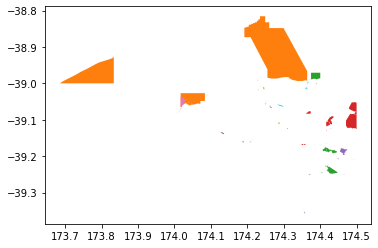

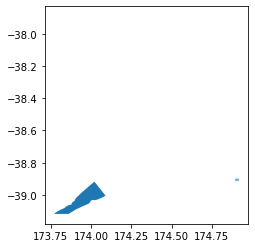

In [12]:
res_petro_intersection = gpd.overlay(petroleum_df, conservation_layer_df, how='intersection')
res_minerals_intersection = gpd.overlay(minerals_df, conservation_layer_df, how='intersection')

petro_ax = res_petro_intersection.plot(cmap='tab10')
minerals_ax = res_minerals_intersection.plot(cmap='tab10')

display(petro_ax, minerals_ax)

In [13]:
def result_click_handler (feature=None, **kwargs):
    if feature is not None:        
        result_html.value = ''
        items = feature['properties']
        for item in items:
            result_html.value += '<h6>{}: <b>{}</b></h6>'.format(item, textwrap.shorten(str(items[item]), width=40))

result_petro_geo_data = GeoData(
    geo_dataframe=res_petro_intersection,
    style={'color': 'blue', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Petroleum Overlapping Area'
)
result_petro_geo_data.on_click(result_click_handler)

result_minerals_geo_data = GeoData(
    geo_dataframe=res_minerals_intersection,
    style={'color': 'red', 'fillColor': '#cc3333', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'green' , 'fillOpacity': 0.2},
    name='Minerals Overlapping Area'
)
result_minerals_geo_data.on_click(result_click_handler)

m = Map(center=(-39.285543, 174.025330), zoom=9, layout=dict(height='1000px'))
m.add_layer(result_petro_geo_data)
m.add_layer(result_minerals_geo_data)

result_html = HTML('')
result_html.layout.margin = '0px 10px 10px 10px'
result_control = WidgetControl(widget=result_html, position='bottomright')
m.add_control(result_control)
m.add_control(LayersControl())

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [14]:
# res_petro_intersection['geometry'] = res_petro_intersection['geometry'].to_crs({'init': 'EPSG:3857'}).map(lambda p: p.area / 10*6)
# conservation_layer_df['geometry'].to_crs({'init': 'EPSG:3857'}).map(lambda p: p.area / 10*6)

# print (res_petro_intersection.area.sum())
# #print (conservation_layer_df['geometry'].area)

# (res_petro_intersection['geometry'].area.sum() / conservation_layer_df['geometry'].area.sum()) * 100

0.0


0.0

In [15]:
res_minerals_intersection = res_minerals_intersection.to_crs({'init': 'EPSG:3857'})

# print (res_minerals_intersection['geometry'].area.sum())

(res_minerals_intersection['geometry'].area.sum() / conservation_layer_df['geometry'].area.sum()) * 100

323692475.74052906


18345824665.067093